<div align="center">

---
# ML1 | AdaBoost Classifier 
Analysis & Optimization
-
---
</div>

<div align = "center">

--- 
## Project Overview
---
</div>

> ADD PROJECT OVERVIEW

<div align = "center">

--- 
## Classifier Selection
---
</div>

> ADD Classifier Selection

<div align = "center">

--- 
## AdaBoost Overview
---
</div>

**AdaBoost** (Adaptive Boosting) is a type of ensemble learning technique used in machine learning to solve both **classification** and **regression** problems. It consists on training a series of weak classifiers on the dataset. Therefore, with each iteration, the algorithm **increases the focus** on data points that were **previously predicted incorrectly**.

As a result, the AdaBoost algorithm builds a model by considering all the individual **weak classifiers** which are **weighted based on their performance**. Consequently, classifiers with **higher predictive accuracy contribute more to the final decision** which **reduces the influence of less accurate ones** in the final prediction. 

Finally, here's the **pseudocode** behind the AdaBoost M1 Algorithm used in this Notebook:

<div align = "center">

--- 
### AdaBoost.M1 [Pseudocode]
---
</div>

1. Initialize the observation weights $w_i = \frac{1}{N}$, for $i = 1, 2, \dots, N$.

2. For $ m = 1 $ to $ M $:
   \
   a) Fit a classifier $ G_m(x) $ to the training data using weights $ w_i $
   \
   b) Compute
      $$
      \text{err}_m = \frac{ \sum_{i=1}^N w_i I(y_i \neq G_m(x_i)) }{ \sum_{i=1}^N w_i }
      $$
   c) Compute $ \alpha_m = \log\left(\frac{1 - \text{err}_m}{\text{err}_m}\right) $
   \
   \
   d) Set $ w_i \leftarrow w_i \cdot \exp\left(\alpha_m \cdot I(y_i \neq G_m(x_i))\right) $, for $ i = 1, 2, \dots, N $.

4. Output $ G(x) = \text{sign}\left( \sum_{m=1}^M \alpha_m G_m(x) \right) $.


> **Source**: *The Elements of Statistical Learning, ch. 10*

<div align = "center">

--- 
### AdaBoost.M1 [Step Guide]
---
</div>

As previously discussed, AdaBoost techniques combine many weak machine-learning models to create a **powerful classification model** for the output which envolves the following steps:

1. **Initialize the Weights**
    - For a dataset with $N$ training data points instances, initialize $N W_{i}$ weights for each data point with $W_{i} = \frac{1}{N}$

<p></p>

2. **Train Weak Classifiers**
    - Train a weak classifier $M_k$ where $k$ is the current iteration
    - The weak classifier we are training should have an accuracy greater than 0.5 which means it should be performing better than a naive guess

<p></p>

3. Calculate the **Error Rate** and **importance of each weak model $M_k$**
    - Calculate rate $error\_rate$ for every weak classifier $M_k$ on the training dataset
    - Calculate the importance of each model $α\_k$ using formula $\alpha_k = \frac{1}{2} \ln{\frac{1 – error_k}{error_k}}$

<p></p>

4. **Update** data point **weight** for each data point $W_i$:
    - After applying the weak classifier model to the training data we will update the weight assigned to the points using the accuracy of the model. The formula for updating the weights will be $w_i = w_i \exp{(-\alpha_k y_i M_k(x_i))}$. Here $y_i$ is the true output and $X_i$ is the corresponding input vector

<p></p>

5. **Normalize the Instance weight**
    - We will normalize the instance weight so that they can be summed up to 1 using the formula $W_i = W_i / sum(W)$

<p></p>

6. **Repeat steps 2-5 for $K \space iterations$**
    - We will train $K \space classifiers$ and will calculate model importance and update the instance weights using the above formula
    - The final model $M(X)$ will be an ensemble model which is obtained by combining these weak models weighted by their model weights

Theoretically the **AdaBoost Algorithm** can use any Machine Learning algorithm as **Weak Learners**. However, depending on the **problem and data** at hand, the final model might require a **more delicate** approcah on it's **evaluation**. Therefore the **best** algorithms to use as **weak learners** are typically those that are **fast**, **simple** and slightly **better than random guess** which is why we started developing this algorithm with **Stumps** (Decision Trees of Depth 1). 

---

In [19]:
# Remove Warnings
import warnings
warnings.filterwarnings('ignore')

# Import Project's Dependencies
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import (train_test_split, KFold, cross_val_score)
from sklearn.metrics import (accuracy_score)
from sklearn.utils import (shuffle)
from sklearn.datasets import (make_classification)
from sklearn.ensemble import (AdaBoostClassifier)
import scikit_posthocs as sp
from AdaBoost import (AdaBoost)
import openml
from DataVisualization import (Display_Confusion_Matrix, Plot_ROC_Curve, Plot_Weak_Learners_Stats)
from ModifiedAdaBoost import (ModifiedAdaBoost)

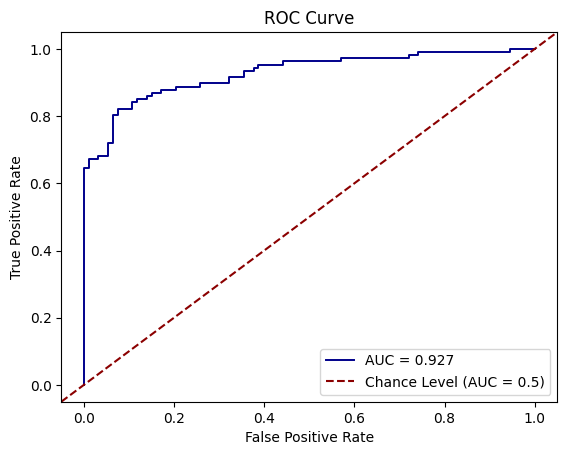

In [8]:
# Generate classification dataset
X, y = make_classification(n_samples= 1000, n_features = 20, random_state = 42)
y = y * 2 - 1       # Original AdaBoost uses {1, -1} as class labels

# Train/test split
X_train, X_test, y_train, y_Test = train_test_split(X, y, test_size = 0.2, random_state = 42)

# Fit model
ab = AdaBoost()
ab.fit(X_train, y_train, M=400)

# Plot the ROC Curve
Plot_ROC_Curve(ab, X_test, y_Test)

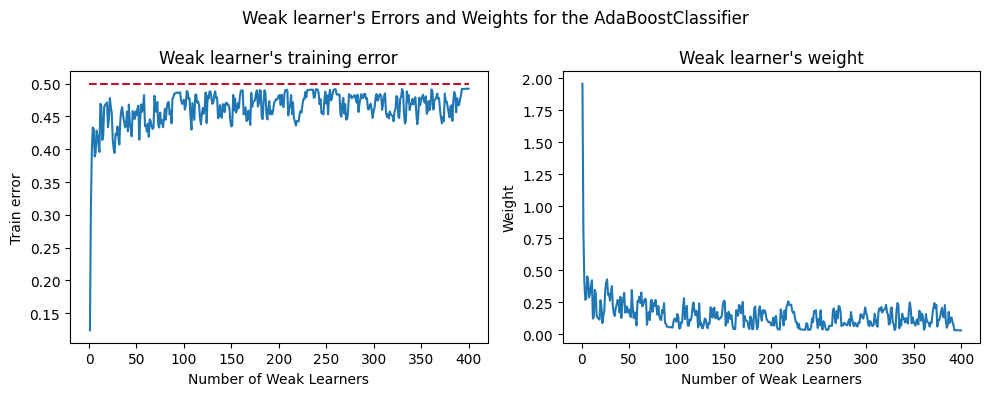

In [9]:
# Weak Learners Statistics
Plot_Weak_Learners_Stats(ab)

<div align = "center">

--- 
## Datasets Selection for Evaluation
---
</div>

In [4]:
def Fetch_Dataset(task_id):
    '''Fetches a Dataset given a OpenML Task ID'''
    # Get OpenML task
    task = openml.tasks.get_task(task_id)

    # Get Dataset
    dataset = openml.datasets.get_dataset(task.dataset_id)

    # Getting the Data
    X, y, categorical_indicator, attribute_names = dataset.get_data(dataset_format="array",
                                                               target=dataset.default_target_attribute)
    # Creating a Dataframe with the Data
    df = pd.DataFrame(X, columns=attribute_names)
    
    # Convert Target Values ({0, 1}) into {-1, 1}:
    df['target'] = (2*y - 1).astype(np.int8)
    
    # Remove rows with NaN values
    df = df.dropna(how='any', axis=0)
    
    return dataset.name, df

def Fetch_X_y(task_id):
    '''Fetches a Dataset given a OpenML Task ID'''
    # Get OpenML task
    task = openml.tasks.get_task(task_id)

    # Get Adjacent Dataset
    dataset = openml.datasets.get_dataset(task.dataset_id)

    # Getting the Data
    X, y, categorical_indicator, attribute_names = dataset.get_data(dataset_format="array",
                                                                    target=dataset.default_target_attribute)
    
    # Creating a Dataframe with the Data
    df = pd.DataFrame(X, columns=attribute_names)
    df['target'] = y
    
    # Remove rows with NaN values
    df = df.dropna(how='any', axis=0)

    # Split the Dataframe once again
    cols = list(df.columns)
    cols.remove('target')
    X = np.array(df[cols])
    y = np.array(df['target'])
    
    # Convert Target Values ({0, 1}) into {-1, 1}:
    y = (2*y - 1).astype(np.int8)
    
    return dataset.name, X, y

Since the AdaBoost Algorithm developed is focuses on Binary Classification Problems, we decided to filter all the datasets from the `OpenML-CC18` study. Therefore, by selecting those that only have 2 possible values for the target we will be capable of properly training our Models.

In [5]:
# List all tasks in the 'OpenML-CC18' benchmark
benchmark = openml.study.get_suite('OpenML-CC18')
df_tasks = openml.tasks.list_tasks(output_format="dataframe", task_id=benchmark.tasks)
df_tasks

,tid,ttid,did,name,task_type,status,estimation_procedure,source_data,target_feature,MajorityClassSize,MaxNominalAttDistinctValues,MinorityClassSize,NumberOfClasses,NumberOfFeatures,NumberOfInstances,NumberOfInstancesWithMissingValues,NumberOfMissingValues,NumberOfNumericFeatures,NumberOfSymbolicFeatures
3,3,TaskType.SUPERVISED_CLASSIFICATION,3,kr-vs-kp,Supervised Classification,active,10-fold Crossvalidation,3,class,1669,3.0,1527,2,37,3196,0,0,0,37
6,6,TaskType.SUPERVISED_CLASSIFICATION,6,letter,Supervised Classification,active,10-fold Crossvalidation,6,class,813,26.0,734,26,17,20000,0,0,16,1
11,11,TaskType.SUPERVISED_CLASSIFICATION,11,balance-scale,Supervised Classification,active,10-fold Crossvalidation,11,class,288,3.0,49,3,5,625,0,0,4,1
12,12,TaskType.SUPERVISED_CLASSIFICATION,12,mfeat-factors,Supervised Classification,active,10-fold Crossvalidation,12,class,200,10.0,200,10,217,2000,0,0,216,1
14,14,TaskType.SUPERVISED_CLASSIFICATION,14,mfeat-fourier,Supervised Classification,active,10-fold Crossvalidation,14,class,200,10.0,200,10,77,2000,0,0,76,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
167121,167121,TaskType.SUPERVISED_CLASSIFICATION,40923,Devnagari-Script,Supervised Classification,active,10-fold Crossvalidation,40923,character,2000,46.0,2000,46,1025,92000,0,0,1024,1
167124,167124,TaskType.SUPERVISED_CLASSIFICATION,40927,CIFAR_10,Supervised Classification,active,10-fold Crossvalidation,40927,class,6000,10.0,6000,10,3073,60000,0,0,3072,1
167125,167125,TaskType.SUPERVISED_CLASSIFICATION,40978,Internet-Advertisements,Supervised Classification,active,10-fold Crossvalidation,40978,class,2820,2.0,459,2,1559,3279,0,0,3,1556
167140,167140,TaskType.SUPERVISED_CLASSIFICATION,40670,dna,Supervised Classification,active,10-fold Crossvalidation,40670,class,1654,3.0,765,3,181,3186,0,0,0,181


In [6]:
my_tasks = {}

for task_id in df_tasks.loc[df_tasks['NumberOfClasses'] == 2]['tid'].to_numpy():
    name, ds = Fetch_Dataset(task_id)
    
    target_values = list(np.unique(ds['target']))
    
    if (len(target_values) > 0 and task_id not in my_tasks.keys()):
        
        features = list(ds.columns[:-1])
        target = ds.columns[-1]
        
        content = {'Name':name,
                   'Features':features,
                   'Target':target,
                   'TargetValues':target_values}
        
        my_tasks.update({task_id: content})

In [7]:
for task_id, info_task in my_tasks.items():
    name, ds = Fetch_Dataset(task_id)
    print(f"[Dataset ID {task_id}]: {info_task['Name']}\n")
    print(f"[Features]: {info_task['Features']}", '\n')
    print(f"[Target]: {info_task['Target']}", '\n')
    print(f"[Target Values]: {info_task['TargetValues']}", '\n')
    print('-'*30, '\n')

[Dataset ID 3]: kr-vs-kp

[Features]: ['bkblk', 'bknwy', 'bkon8', 'bkona', 'bkspr', 'bkxbq', 'bkxcr', 'bkxwp', 'blxwp', 'bxqsq', 'cntxt', 'dsopp', 'dwipd', 'hdchk', 'katri', 'mulch', 'qxmsq', 'r2ar8', 'reskd', 'reskr', 'rimmx', 'rkxwp', 'rxmsq', 'simpl', 'skach', 'skewr', 'skrxp', 'spcop', 'stlmt', 'thrsk', 'wkcti', 'wkna8', 'wknck', 'wkovl', 'wkpos', 'wtoeg'] 

[Target]: target 

[Target Values]: [-1, 1] 

------------------------------ 

[Dataset ID 15]: breast-w

[Features]: ['Clump_Thickness', 'Cell_Size_Uniformity', 'Cell_Shape_Uniformity', 'Marginal_Adhesion', 'Single_Epi_Cell_Size', 'Bare_Nuclei', 'Bland_Chromatin', 'Normal_Nucleoli', 'Mitoses'] 

[Target]: target 

[Target Values]: [-1, 1] 

------------------------------ 

[Dataset ID 29]: credit-approval

[Features]: ['A1', 'A2', 'A3', 'A4', 'A5', 'A6', 'A7', 'A8', 'A9', 'A10', 'A11', 'A12', 'A13', 'A14', 'A15'] 

[Target]: target 

[Target Values]: [-1, 1] 

------------------------------ 

[Dataset ID 31]: credit-g

[Featur

<div align = "center">

--- 
## Base Model Evaluation
---
</div>

In [8]:
def Perform_KFold_CV(X, y, model):
    # Set the K-Fold cross-validation
    kf = KFold(n_splits=5, shuffle=True, random_state=123)
    
    # Perform K-Fold cross-validation
    scores = cross_val_score(model, X, y, cv=kf, scoring='accuracy')

    # Calculate accuracie's mean and std
    Avg_Accuracy = np.mean(scores)
    Avg_Std = np.mean(scores.std())
    
    return Avg_Accuracy, Avg_Std

def Evaluate_Model(task_id, model):
    # Get Features and Target
    ds_name, X, y = Fetch_X_y(task_id)

    if (len(X) > 0):
        # Perform K-Fold Cross Validation
        Avg_Accuracy, Avg_Std = Perform_KFold_CV(X, y, model)
    
        # Print Results
        print(f"[DATASET] {ds_name}\n[Average Accuracy] {Avg_Accuracy:1.3f} +/- {Avg_Std:1.3f}")

def Evaluate_Model_AllDS(tasks, model):
    # Evaluate all Datasets Retrieved
    for task_id in tasks.keys():
        Evaluate_Model(task_id, model)
        print()
        

In [9]:
# Sklearn Base AdaBoost
model = AdaBoostClassifier()
Evaluate_Model_AllDS(my_tasks, model)

[DATASET] kr-vs-kp
[Average Accuracy] 0.964 +/- 0.010

[DATASET] breast-w
[Average Accuracy] 0.956 +/- 0.012

[DATASET] credit-approval
[Average Accuracy] 0.850 +/- 0.016

[DATASET] credit-g
[Average Accuracy] 0.753 +/- 0.025

[DATASET] diabetes
[Average Accuracy] 0.751 +/- 0.021

[DATASET] spambase
[Average Accuracy] 0.940 +/- 0.014

[DATASET] tic-tac-toe
[Average Accuracy] 0.773 +/- 0.026

[DATASET] electricity
[Average Accuracy] 0.812 +/- 0.005

[DATASET] pc4
[Average Accuracy] 0.902 +/- 0.013

[DATASET] pc3
[Average Accuracy] 0.885 +/- 0.006

[DATASET] jm1
[Average Accuracy] 0.811 +/- 0.012

[DATASET] kc2
[Average Accuracy] 0.833 +/- 0.018

[DATASET] kc1
[Average Accuracy] 0.860 +/- 0.019

[DATASET] pc1
[Average Accuracy] 0.931 +/- 0.015

[DATASET] adult
[Average Accuracy] 0.857 +/- 0.004

[DATASET] Bioresponse
[Average Accuracy] 0.765 +/- 0.006

[DATASET] wdbc
[Average Accuracy] 0.958 +/- 0.014

[DATASET] phoneme
[Average Accuracy] 0.817 +/- 0.010

[DATASET] qsar-biodeg
[Average A

In [10]:
# Base Model Implementation
model = AdaBoost()
Evaluate_Model_AllDS(my_tasks, model)

[DATASET] kr-vs-kp
[Average Accuracy] 0.952 +/- 0.011

[DATASET] breast-w
[Average Accuracy] 0.960 +/- 0.014

[DATASET] credit-approval
[Average Accuracy] 0.862 +/- 0.022

[DATASET] credit-g
[Average Accuracy] 0.759 +/- 0.026

[DATASET] diabetes
[Average Accuracy] 0.762 +/- 0.022

[DATASET] spambase
[Average Accuracy] 0.939 +/- 0.008

[DATASET] tic-tac-toe
[Average Accuracy] 0.772 +/- 0.025

[DATASET] electricity
[Average Accuracy] 0.795 +/- 0.006

[DATASET] pc4
[Average Accuracy] 0.901 +/- 0.008

[DATASET] pc3
[Average Accuracy] 0.887 +/- 0.007

[DATASET] jm1
[Average Accuracy] 0.811 +/- 0.010

[DATASET] kc2
[Average Accuracy] 0.835 +/- 0.029

[DATASET] kc1
[Average Accuracy] 0.852 +/- 0.017

[DATASET] pc1
[Average Accuracy] 0.931 +/- 0.020

[DATASET] adult
[Average Accuracy] 0.851 +/- 0.004

[DATASET] Bioresponse
[Average Accuracy] 0.763 +/- 0.007

[DATASET] wdbc
[Average Accuracy] 0.961 +/- 0.013

[DATASET] phoneme
[Average Accuracy] 0.798 +/- 0.011

[DATASET] qsar-biodeg
[Average A

In [11]:
# Modified AdaBoost with Perceptron
model = ModifiedAdaBoost()
Evaluate_Model_AllDS(my_tasks, model)

[DATASET] kr-vs-kp
[Average Accuracy] 0.962 +/- 0.006

[DATASET] breast-w
[Average Accuracy] 0.959 +/- 0.010

[DATASET] credit-approval
[Average Accuracy] 0.689 +/- 0.017

[DATASET] credit-g
[Average Accuracy] 0.698 +/- 0.019

[DATASET] diabetes
[Average Accuracy] 0.646 +/- 0.017

[DATASET] spambase
[Average Accuracy] 0.840 +/- 0.045

[DATASET] tic-tac-toe
[Average Accuracy] 0.645 +/- 0.015

[DATASET] electricity
[Average Accuracy] 0.714 +/- 0.023

[DATASET] pc4
[Average Accuracy] 0.847 +/- 0.024

[DATASET] pc3
[Average Accuracy] 0.866 +/- 0.039

[DATASET] jm1
[Average Accuracy] 0.798 +/- 0.013

[DATASET] kc2
[Average Accuracy] 0.795 +/- 0.047

[DATASET] kc1
[Average Accuracy] 0.786 +/- 0.120

[DATASET] pc1
[Average Accuracy] 0.909 +/- 0.022

[DATASET] adult
[Average Accuracy] 0.786 +/- 0.003

[DATASET] Bioresponse
[Average Accuracy] 0.725 +/- 0.009

[DATASET] wdbc
[Average Accuracy] 0.910 +/- 0.024

[DATASET] phoneme
[Average Accuracy] 0.765 +/- 0.022

[DATASET] qsar-biodeg
[Average A

In [12]:
# IDEA: PLOT ROC CURVE & AUC, CONFUSION MATRIX.
# LATER: 
# -> ADD A PAIR PLOT TO COMPARE THE DIFFERENCES BETWEEN BOTH ALGORITHMS (ORIGINAL AND MODIFIED)
# -> ADD A CRITIAL DIFERENCE REGION

---
# Tests [REMOVE LATER]

In [36]:
from sklearn.tree import DecisionTreeClassifier

# Generate classification dataset
X, y = make_classification(n_samples= 1000, n_features = 20, random_state = 42)
y = y * 2 - 1       # Original AdaBoost uses {1, -1} as class labels

# Train/test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)

# Fit model
ab1 = AdaBoost()
ab1.fit(X_train, y_train, M=400)

ab2 = DecisionTreeClassifier()
ab2.fit(X_train, y_train)

DecisionTreeClassifier()

In [37]:
ab1_preds = ab1.predict(X_test)
ab2_preds = ab2.predict(X_test)

In [38]:
def permutation_test_p_value(model1_preds, model2_preds, y_true, n_permutations=1000):
    # Calculate the observed difference in accuracy
    observed_accuracy_diff = abs(accuracy_score(y_true, model1_preds) - accuracy_score(y_true, model2_preds))
    
    # Combine the predictions for permutation
    combined_predictions = np.vstack((model1_preds, model2_preds))
    
    count = 0
    for _ in range(n_permutations):
        # Permute the labels of the combined predictions
        shuffled_preds = shuffle(combined_predictions, random_state=None)
        
        # Calculate new accuracies and their difference
        accuracy_diff = abs(accuracy_score(y_true, shuffled_preds[0, :]) - accuracy_score(y_true, shuffled_preds[1, :]))
        
        # Check if the permuted accuracy difference is as extreme as the observed one
        if accuracy_diff >= observed_accuracy_diff:
            count += 1
    
    # Compute the p-value
    p_value = count / n_permutations
    return p_value

# Usage example with hypothetical data
# model1_preds and model2_preds are the prediction arrays from each model
# y_true is the array of true labels
p_value = permutation_test_p_value(ab1_preds, ab2_preds, y_test)
print(f"P-value: {p_value:1.5f}")

P-value: 1.00000


In [ ]:
import numpy as np
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.datasets import load_iris

# Load data
data = load_iris()
X = data.data
y = data.target

# Define models
model1 = RandomForestClassifier(random_state=1)
model2 = AdaBoostClassifier(random_state=1)

# Compute observed accuracies
scores1 = cross_val_score(model1, X, y, cv=5)
scores2 = cross_val_score(model2, X, y, cv=5)

# Observed difference
obs_diff = np.abs(np.mean(scores1) - np.mean(scores2))

# Permutation test
num_permutations = 1000
count = 0

for _ in range(num_permutations):
    # Shuffle the labels
    np.random.shuffle(y)
    
    # Compute new accuracies
    new_scores1 = cross_val_score(model1, X, y, cv=5)
    new_scores2 = cross_val_score(model2, X, y, cv=5)
    
    # Compute difference
    new_diff = np.abs(np.mean(new_scores1) - np.mean(new_scores2))
    
    # Count how many times the permuted difference is greater than the observed difference
    if new_diff >= obs_diff:
        count += 1

# Calculate p-value
p_value = count / num_permutations

print("P-value:", p_value)

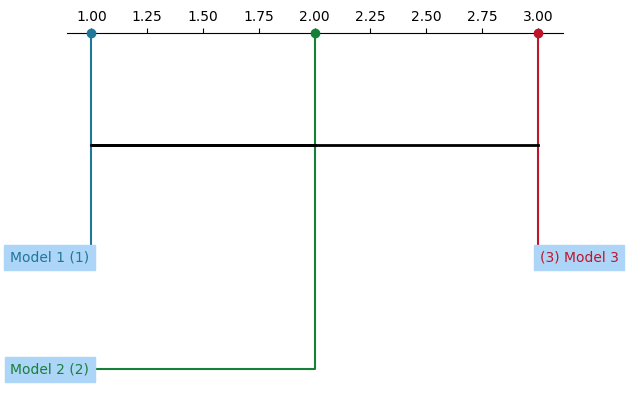

In [13]:
# Sample rankings and p-value matrix
# This is usually obtained from the actual model performance data and post-hoc testing
ranks = {'Model 1': 1, 'Model 2': 2, 'Model 3': 3}

# p_values = pd.DataFrame(
#     [[1.0, 0.07, 0.01],
#      [0.07, 1.0, 0.05],
#      [0.01, 0.05, 1.0]],
#     index=['Model 1', 'Model 2', 'Model 3'],
#     columns=['Model 1', 'Model 2', 'Model 3']
# )

p_values = pd.DataFrame(
    [[1.0, 0.7, 0.1],
     [0.7, 1.0, 0.05],
     [0.1, 0.05, 1.0]],
    index=['Model 1', 'Model 2', 'Model 3'],
    columns=['Model 1', 'Model 2', 'Model 3']
)

colors = {'Model 1':'#1F7799', 'Model 2':'#168039', 'Model 3':'#bd162c'}

marker = {'marker':'o', 'linewidth':1}

label_props = {'backgroundcolor':'#ADD5F7', 'verticalalignment':'top'}

# Plot the Critical Difference Diagram
_ = sp.critical_difference_diagram(ranks, p_values, color_palette=colors, marker_props=marker, label_props=label_props)

<div align="center">

***
## Bibliographic References
***
</div>

1. Cano. Alvaro (Towards Data Science, 2021). __*AdaBoost from Scratch*__. Available [here](https://towardsdatascience.com/adaboost-from-scratch-37a936da3d50)
2. Geeks For Geeks (2023). __*Boosting in Machine Learning | Boosting and AdaBoost*__. Available [here](https://www.geeksforgeeks.org/boosting-in-machine-learning-boosting-and-adaboost/)
3. Geeks For Geeks (2024). __*Implementing the AdaBoost Algorithm from Scratch*__. Available [here](https://www.geeksforgeeks.org/implementing-the-adaboost-algorithm-from-scratch/)

___
## Final Considerations

$\quad$ If there is any difficulty on downloading or executing this project, please contact us via:

- **Email**:
    - [Gonçalo Esteves](https://github.com/EstevesX10) &#8594; `up202203947@up.pt`
    - [Nuno Gomes](https://github.com/NightF0x26) &#8594; `up202206195@up.pt`